# Step 1: 下載資料集與定義模型


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.quantization import quantize_dynamic
import os

In [ ]:
# 定義資料轉換
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# 定義自定義輕量模型
class CustomNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((7, 7))  # 確保特徵圖固定為 7x7
        )
        # 自動計算展平後的大小
        self._initialize_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 128),  # 動態設置
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def _initialize_flatten_size(self):
        """用於計算展平後的大小"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR10 輸入大小
            dummy_output = self.features(dummy_input)
            self.flatten_size = dummy_output.numel()  # 展平後的特徵大小

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平特徵
        x = self.classifier(x)
        return x

In [ ]:
# CIFAR10 訓練和測試數據集
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 載入模型
model = CustomNet(num_classes=10)
print("Model before quantization:")
print(model)


Model before quantization:
CustomNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Step 2: 訓練模型


In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast
# 定義損失函數和優化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 移動模型到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
model = model.to(device)
scaler = GradScaler()
# 訓練函數
def train(model, trainloader, optimizer, criterion, device='cuda', epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # 使用新的 autocast API
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

# 訓練模型
train(model, trainloader, optimizer, criterion, epochs=20, device=device)
# 儲存訓練後的模型
torch.save(model.state_dict(), "model_trained.pth")
print(f"Trained Model Size: {os.path.getsize('model_trained.pth') / 1024 ** 2:.2f} MB")


Using device: cuda


Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1, Loss: 1.5920


Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2, Loss: 1.3804


Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3, Loss: 1.3020


Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4, Loss: 1.2460


Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5, Loss: 1.1870


Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6, Loss: 1.1279


Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7, Loss: 1.0803


Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8, Loss: 1.0355


Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9, Loss: 0.9878


Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10, Loss: 0.9422


Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11, Loss: 0.9016


Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12, Loss: 0.8611


Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13, Loss: 0.8247


Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14, Loss: 0.7941


Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15, Loss: 0.7590


Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16, Loss: 0.7286


Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17, Loss: 0.6956


Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18, Loss: 0.6669


Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19, Loss: 0.6404


Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20, Loss: 0.6164
Trained Model Size: 0.79 MB


# Step 3: 模型動態量化


In [ ]:
# 將訓練好的模型設為評估模式
model.eval()

# 動態量化
quantized_model = quantize_dynamic(
    model.cpu(),  # 將模型移動到 CPU
    {torch.nn.Linear},  # 僅量化全連接層
    dtype=torch.qint8  # 使用 8-bit 量化
)

# 儲存量化後的模型
torch.save(quantized_model.state_dict(), "customnet_quantized.pth")
print(f"Quantized Model Size: {os.path.getsize('customnet_quantized.pth') / 1024 ** 2:.2f} MB")

Quantized Model Size: 0.22 MB


# Step 4: 評估模型準確度與推理性能


In [ ]:
# 計算模型準確度的函數
def evaluate(model, dataloader, device='cpu'):
    """
    計算模型的準確度
    :param model: 待評估的模型
    :param dataloader: 測試數據的 DataLoader
    :param device: 運行設備 ('cpu' 或 'cuda')
    :return: 模型的準確度 (%)
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy

# 測試推理時間
def measure_inference_time(model, input_tensor, device='cpu'):
    model.to(device)
    input_tensor = input_tensor.to(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):  # 模擬多次推理
            model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) / 100

# 測試模型
input_tensor = next(iter(testloader))[0][0].unsqueeze(0)  # 獲取單張測試圖片



In [ ]:
# 原始模型準確度
original_accuracy = evaluate(model, testloader, device='cuda')
# original_time = measure_inference_time(model, input_tensor, device='cuda')
print(f"Original Model Accuracy: {original_accuracy:.2f}%")
# print(f"Original Model Inference Time: {original_time * 1000:.2f} ms")

Evaluating:   0%|          | 0/157 [00:00<?, ?batch/s]

Original Model Accuracy: 61.22%


In [ ]:
# 量化模型準確度
quantized_accuracy = evaluate(quantized_model, testloader, device='cpu')
# quantized_time = measure_inference_time(quantized_model, input_tensor, device='cpu')
print(f"Quantized Model Accuracy: {quantized_accuracy:.2f}%")
# print(f"Quantized Model Inference Time: {quantized_time * 1000:.2f} ms")

Evaluating:   0%|          | 0/157 [00:00<?, ?batch/s]

Quantized Model Accuracy: 61.39%


# Step 5: 視覺化結果


Original Model Size: 0.79 MB
Quantized Model Size: 0.22 MB
Compression Ratio: 3.65


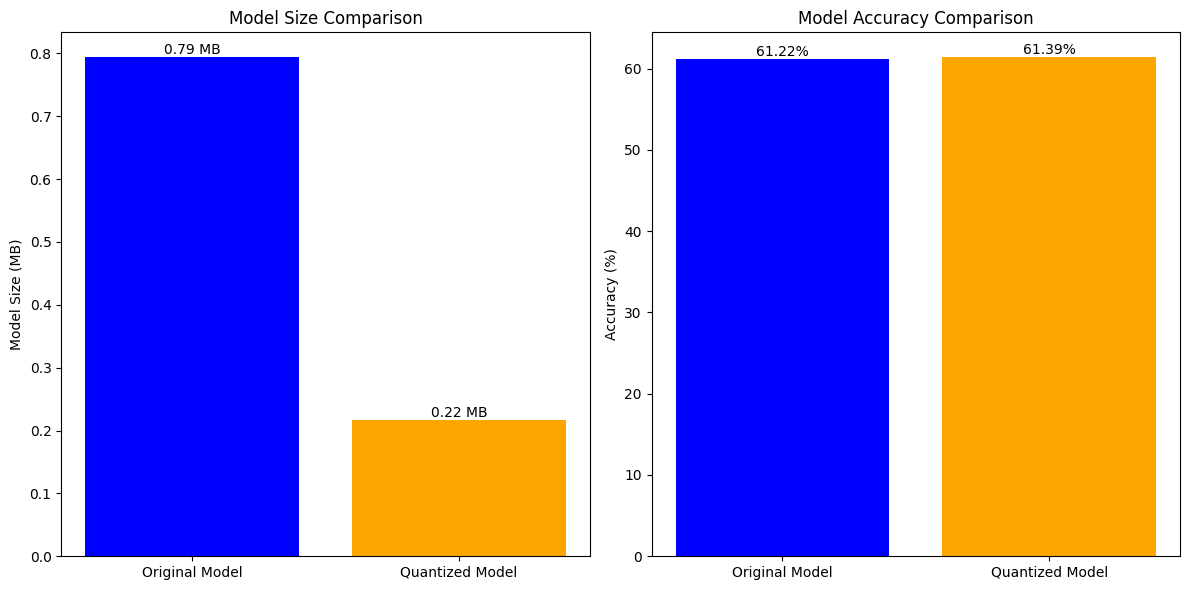

In [ ]:
import matplotlib.pyplot as plt

# 計算模型大小
original_model_size = os.path.getsize('model_trained.pth') / 1024 ** 2  # 原始模型大小 (MB)
quantized_model_size = os.path.getsize('customnet_quantized.pth') / 1024 ** 2  # 量化模型大小 (MB)
compression_ratio = original_model_size / quantized_model_size
print(f"Original Model Size: {original_model_size:.2f} MB")
print(f"Quantized Model Size: {quantized_model_size:.2f} MB")
print(f'Compression Ratio: {compression_ratio:.2f}')
# 視覺化模型大小比較
plt.figure(figsize=(12, 6))

# 模型大小比較圖
plt.subplot(1, 2, 1)
bars = plt.bar(['Original Model', 'Quantized Model'],
               [original_model_size, quantized_model_size],
               color=['blue', 'orange'])
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{bar.get_height():.2f} MB',
             ha='center', va='bottom')

# 模型準確度比較圖
plt.subplot(1, 2, 2)
bars = plt.bar(['Original Model', 'Quantized Model'],
               [original_accuracy, quantized_accuracy],
               color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{bar.get_height():.2f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()